<font size=3>This notebook presents a <i>neural architecture search (NAS)</i> method for finding optimal neural network architecture for churn dataset. I utilized a <i>genetic algorithm (GA)</i> to evolve the architecture of a Torch-based NN for a classification task. The GA searches the space of possible network architectures by mutating and recombining existing architectures, evaluating their performance on the test set, and selecting the best-performing architectures for the next generation. The fitness function is based on the validation accuracy of each network, and the genetic operators include mutation, crossover, and selection. I compared our NAS method with a baseline network and a manually designed network, and found that the NAS method outperformed in terms of accuracy about ~1%. The results demonstrate the effectiveness of the GA-based NAS method for automating the design of neural network architectures and achieving state-of-the-art performance on classification tasks.
The space has limited to:

 - Three activation function: Sigmoid, Tanh, ReLU
 - Three optimizer algorithms: Adam, RMSprop, SGD
 - Two loss functions: Cross Entropy, Binary Cross Entropy

I did not try to search the space of number of layers, and parameters as this is a PoC for NAS with GA. The process takes time. For making better results, one can increase <b>MAX_GENERATIONS</b>, <b>POPULATION_SIZE</b>, and <b>epochs</b> size.
The techniques I used are as follows:
 - Elitism: Individuals in each generation might be removed or mutated. And this phenomenon might hurt the best   individuals. So we use Elitisim to prevent mutating and removing best individuals of each generation and we inject them directly to the next generation.
 - Tournament selection: A selection strategy where a subset of individuals is randomly chosen from the population(here 2), and the fittest individual is selected based on a fitness function.
 - Mate (SimulatedBinaryBounded): Simulated Binary Bounded crossover is a variant of cross over strategy that ensures the offspring's genetic information remains within a predefined range.
 - Mutation (PolynomialBounded): Mutation happens to create new individuals by changing the current inds. Polynomial Bounded mutation is a method that limits the magnitude of the changes and ensures the new genetic information remains within a predefined range.

After finding the suitable elements, we use model_hype_opt to find learning rate and dropout. 
</font>

In [1]:
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt
import seaborn as sns

import random
import pandas
import numpy

import torch
import torch.nn as nn

from util import util, torch_model_arch, elitism

#### Preparation

In [2]:
data = pandas.read_csv(util.dataset_filename)
data.drop(['customerID'], axis=1, inplace=True)

data[util.target_column] = data[util.target_column].replace(['Yes', 'No'], [1.0, 0.0])
data = util.integrating_numerical_column(util.numerical_columns[0], data)
data = util.standard_rescaling(util.numerical_columns, data)
data = util.one_hot_encoding(util.categorized_columns, data)

#### Tensors' journey

In [23]:
dropout_prob = 0.15
batch_size = 5
epochs = 6
test_prob = 0.1
train_loader, test_loader, input_size, \
    classifiers_size, test_size = util.data_splitter_tensor_binary(data, util.target_column, batch_size, test_prob)

# Defining search space
optimizer_space = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.SGD]
loss_func_space = [nn.BCEWithLogitsLoss, nn.CrossEntropyLoss]
activation_space = [nn.Sigmoid, nn.ReLU, nn.Tanh]

def feedback(optimizer, loss_func, act_l1, act_l2):
    torch.manual_seed(util.seed)
    model = torch_model_arch.net_search(input_size, classifiers_size, dropout_prob, [activation_space[act_l1], activation_space[act_l2]])
    model.to(util.device)
    model_loss = loss_func_space[loss_func]().to(util.device)
    model_optimizer = optimizer_space[optimizer](model.parameters(), lr=1e-5)
    # Training loop    
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader, 0):
            outputs = model(inputs)
            loss = model_loss(outputs, labels)
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
    # Test    
    model.eval()
    y_test = []
    y_pred = []
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            logits = model(inputs)
            batch_pred = torch.argmax(logits, dim=1)
            batch_labels = torch.argmax(labels, dim=1)
            y_test.extend(batch_labels.cpu().tolist())
            y_pred.extend(batch_pred.cpu().tolist())
            correct += (batch_pred == batch_labels).sum().item()

    return correct/test_size

#### Search

gen	nevals	max     	avg     
0  	20    	0.821277	0.787943
1  	15    	0.821277	0.809574
2  	16    	0.821277	0.81844 
3  	17    	0.821277	0.820142
4  	17    	0.821277	0.820922
5  	14    	0.821277	0.821277
6  	16    	0.821277	0.821135
7  	15    	0.821277	0.821135
8  	17    	0.821277	0.821277
9  	16    	0.821277	0.821277
10 	17    	0.821277	0.821277
11 	16    	0.821277	0.821277
12 	16    	0.821277	0.821277
13 	16    	0.821277	0.821135
14 	16    	0.821277	0.821277
15 	16    	0.821277	0.821277
16 	14    	0.821277	0.820851
17 	16    	0.821277	0.821277
18 	17    	0.821277	0.821277
19 	16    	0.821277	0.821277
20 	14    	0.821277	0.821135
21 	16    	0.821277	0.821277
Best elements are: 
params =  [0, 1, 1.7695264336521022, 1] 0.9423816084130255
Accuracy = 0.8212765957446808


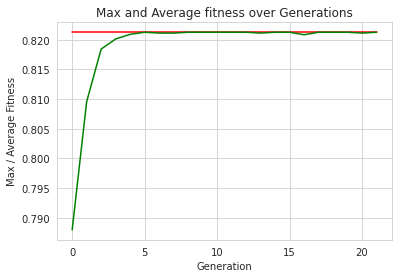

In [25]:
def fitness_func(vals):
    params = [round(x) for x in vals]
    return feedback(*params),

# Space encoding: optim, loss, act_f(l1), act_f(l2)
BOUNDS_LOW =  [0, 0, 0, 0]
BOUNDS_HIGH = [2, 1, 2, 2]


NUM_OF_PARAMS = len(BOUNDS_HIGH)


POPULATION_SIZE = 20
P_CROSSOVER = 0.9      # Prob for crossover
P_MUTATION = 0.5       # Prob for mutation
MAX_GENERATIONS = 21
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0 # Crowding factor for crossover and mutation

toolbox = base.Toolbox()

# Maximizing fitness function
creator.create('fitness_max', base.Fitness, weights=(1.0,))

# Each individual is a list of params
creator.create('individual', list, fitness=creator.fitness_max)


for i in range(NUM_OF_PARAMS):
    toolbox.register('param_' + str(i),
                     random.randint,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])
attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes = attributes + (toolbox.__getattribute__('param_' + str(i)),)

# Create the individual operator to fill up an Individual instance
toolbox.register('individual_creator',
                 tools.initCycle,
                 creator.individual,
                 attributes,
                 n=1)

# Create the population operator to generate a list of individuals
toolbox.register('population_creator', tools.initRepeat, list, toolbox.individual_creator)

toolbox.register('evaluate', fitness_func)


toolbox.register('select', tools.selTournament, tournsize=2)
toolbox.register('mate',
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register('mutate',
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)


def search():
    population = toolbox.population_creator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('max', numpy.max)
    stats.register('avg', numpy.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = elitism.eaSimpleWithElitism(\
        population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    print('Best elements are: ')
    print('params = ', hof.items[0], sum(hof.items[0])/len(hof.items[0]))
    print(f'Accuracy = {hof.items[0].fitness.values[0]}')

    max_fit, mean_fit = logbook.select('max', 'avg')

    sns.set_style('whitegrid')
    plt.plot(max_fit, color='red')
    plt.plot(mean_fit, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()


search()

In [26]:
params = [0, 1, 1.7695264336521022, 1]
params = [round(x) for x in params]

print('Selected optimizer:', optimizer_space[params[0]].__name__)
print('Selected loss function:', loss_func_space[params[1]].__name__)
print('Selected activation function(layer1):', activation_space[params[2]].__name__)
print('Selected activation function(layer2):', activation_space[params[3]].__name__)

Selected optimizer: RMSprop
Selected loss function: CrossEntropyLoss
Selected activation function(layer1): Tanh
Selected activation function(layer2): ReLU


In [27]:
feedback(*params)

0.8212765957446808

Almost near what I've chosen(RMSprop, CE, Sigmoid, ReLU) but with one difference: Using Tanh instead of Sigmoid.